# Walk-forward оптимизация VolatilityMedian + SlopeSignal

Демонстрация rolling walk-forward (2м/3м in-sample → 1м out-of-sample) с использованием внутренних модулей оптимизации. Ноутбук можно адаптировать под другие индикаторы, сигналы и сетки параметров.

In [1]:
import sys
from pathlib import Path

project_root = Path.cwd()
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

from dataclasses import dataclass, field
from typing import Any, Callable, Dict, Mapping, Optional, Sequence

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from data import CSVLoader
from optimization import (
    GridSearchStrategy,
    InMemoryResultsStore,
    OptimizationExecutor,
    OptimizationReporter,
    OptimizationResult,
    ParameterDefinition,
    ParameterSpace,
    RandomSearchStrategy,
)
from optimization.executor import SignalConfig
from backtest.engine import BacktestEngine
from backtest.metrics import MetricsCalculator
from indicators.indicator_registry import IndicatorRegistry
from signals.signal_registry import SignalRegistry

plt.style.use("seaborn-v0_8")
pd.options.display.max_rows = 20

In [2]:
pd.set_option("display.max_rows", 400)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

## Источник данных

In [52]:
DATA_DIR = r"G:\My Drive\data_fut"
TICKER = "GAZR"
TIMEFRAME = 5

START_DATE = "2024-01-15"
END_DATE = "2025-11-15"

loader = CSVLoader(DATA_DIR, use_cache=True)
print(f"Источник данных: {DATA_DIR} | тикер: {TICKER} | таймфрейм: {TIMEFRAME} минут")

Источник данных: G:\My Drive\data_fut | тикер: GAZR | таймфрейм: 5 минут


## Конфигурация walk-forward окон

In [53]:
WINDOW_CONFIG = {
    "train_window_days": 45,
    "test_window_days": 22,
    "step_days": None,  # None → шаг равен длине тестового окна
    "min_train_bars": 1_500,
    "min_test_bars": 600,
}

ALTERNATIVE_WINDOWS = {
    "2m+1m": {"train_window_days": 150, "test_window_days": 22},
    "3m+1m": {"train_window_days": 180, "test_window_days": 22},
}

print("Текущая конфигурация окон:", WINDOW_CONFIG)

Текущая конфигурация окон: {'train_window_days': 45, 'test_window_days': 22, 'step_days': None, 'min_train_bars': 1500, 'min_test_bars': 600}


## Параметрическое пространство индикатора и сигнала

In [55]:
PARAMETER_GRID = {
    "KATR": [2, 3, 4, 5, 6, 7, 8, 9, 10],
    "PerATR": [2, 10, 30, 60],
    "SMA": [1, 2, 3, 5, 7],
    "MinRA": [0],
    "FlATR": [0],
    "FlHL": [0],
    "SlopeSignal": [0.0001],
}

INDICATOR_NAME = "VolatilityMedian"
SIGNAL_NAME = "SlopeSignal"

PARAMETER_ROUTING = {
    "indicator_keys": ["KATR", "PerATR", "SMA", "MinRA", "FlATR", "FlHL"],
    "signal_mapping": {"SlopeSignal": "threshold"},
}

INDICATOR_BASE_PARAMS: Dict[str, Any] = {}
SIGNAL_BASE_PARAMS: Dict[str, Any] = {"absolute": False}

BACKTEST_ENGINE_CONFIG = {
    "initial_capital": 100_000.0,
    "default_n_contracts": 1,
}
BACKTEST_PARAMS = {"entry_price_type": "close", "n_contracts": 1}

BACKTEST_ENGINE_CONFIG = {
    "initial_capital": 100_000.0,
    "default_n_contracts": 1,
    "calculate_wave_metrics": False,  # Отключить wave-метрики для избежания ошибок при малом числе сделок
}

In [56]:
OPTIMIZATION_CONFIG = {
    "strategy": "grid",  # grid или random
    "key_metric": "recovery_factor",
    "random_iterations": 500,
    "random_seed": 42,
    "max_workers": 1,
}

print("Конфигурация оптимизации:", OPTIMIZATION_CONFIG)

Конфигурация оптимизации: {'strategy': 'grid', 'key_metric': 'recovery_factor', 'random_iterations': 500, 'random_seed': 42, 'max_workers': 1}


## Вспомогательные структуры и функции

In [57]:
@dataclass
class WindowSlice:
    idx: int
    train_df: pd.DataFrame
    test_df: pd.DataFrame
    train_start: pd.Timestamp
    train_end: pd.Timestamp
    test_start: pd.Timestamp
    test_end: pd.Timestamp


@dataclass
class IndicatorSignalFactory:
    indicator_name: str
    signal_name: str
    indicator_keys: Sequence[str]
    signal_mapping: Mapping[str, str]
    indicator_overrides: Mapping[str, Any] = field(default_factory=dict)
    signal_overrides: Mapping[str, Any] = field(default_factory=dict)
    backtest_params: Mapping[str, Any] = field(default_factory=dict)

    def __post_init__(self) -> None:
        self._indicator_cls = type(IndicatorRegistry.get(self.indicator_name))
        self._signal_cls = type(SignalRegistry.get(self.signal_name))

    def create(self, parameters: Mapping[str, Any]) -> SignalConfig:
        indicator_params = dict(self.indicator_overrides)
        for key in self.indicator_keys:
            if key in parameters:
                indicator_params[key] = parameters[key]
        signal_params = dict(self.signal_overrides)
        for param_name, signal_kw in self.signal_mapping.items():
            if param_name in parameters:
                signal_params[signal_kw] = parameters[param_name]
        signal = self._signal_cls()
        return SignalConfig(
            signal=signal,
            signal_params=signal_params,
            indicator_params=indicator_params,
            backtest_params=dict(self.backtest_params),
        )

    def indicator_builder(self, df: pd.DataFrame, indicator_params: Mapping[str, Any]) -> pd.Series:
        indicator = self._indicator_cls()
        return indicator.calculate(df, **indicator_params)


def build_parameter_space_from_grid(grid: Mapping[str, Sequence[Any]]) -> ParameterSpace:
    definitions = [
        ParameterDefinition(name=name, values=tuple(values))
        for name, values in grid.items()
    ]
    return ParameterSpace.from_definitions(definitions)


def create_strategy_factory(config: Mapping[str, Any], sampler: ParameterSpace) -> Callable[[], object]:
    strategy_name = config.get("strategy", "grid").lower()
    random_iterations = config.get("random_iterations")
    random_seed = config.get("random_seed")

    def _factory():
        if strategy_name == "random":
            return RandomSearchStrategy(
                sampler,
                max_iterations=random_iterations,
                random_seed=random_seed,
            )
        return GridSearchStrategy(sampler)

    return _factory


def generate_walk_forward_windows(
    df: pd.DataFrame,
    *,
    train_days: int,
    test_days: int,
    step_days: Optional[int],
    min_train_bars: int,
    min_test_bars: int,
) -> list[WindowSlice]:
    df_sorted = df.sort_index()
    if df_sorted.empty:
        raise ValueError("Пустой датафрейм")
    step = pd.Timedelta(days=step_days or test_days)
    train_delta = pd.Timedelta(days=train_days)
    test_delta = pd.Timedelta(days=test_days)
    cursor = df_sorted.index.min()
    final_time = df_sorted.index.max()
    windows: list[WindowSlice] = []

    while True:
        train_start = cursor
        train_end = train_start + train_delta
        test_start = train_end
        test_end = test_start + test_delta
        if test_start >= final_time:
            break
        train_slice = df_sorted.loc[(df_sorted.index >= train_start) & (df_sorted.index < train_end)]
        test_slice = df_sorted.loc[(df_sorted.index >= test_start) & (df_sorted.index < test_end)]
        if len(train_slice) < min_train_bars or len(test_slice) < min_test_bars:
            break
        idx = len(windows) + 1
        windows.append(
            WindowSlice(
                idx=idx,
                train_df=train_slice,
                test_df=test_slice,
                train_start=train_slice.index[0],
                train_end=train_slice.index[-1],
                test_start=test_slice.index[0],
                test_end=test_slice.index[-1],
            )
        )
        cursor = cursor + step

    return windows


def run_backtest_for_parameters(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    parameters: Mapping[str, Any],
    *,
    signal_factory: IndicatorSignalFactory,
    indicator_builder: Callable[[pd.DataFrame, Mapping[str, Any]], pd.Series],
    backtest_engine_cfg: Mapping[str, Any],
    initial_capital: float,
) -> Dict[str, Any]:
    config = signal_factory.create(parameters)
    combined = pd.concat([train_df, test_df]).sort_index()
    indicator_series = indicator_builder(combined, config.indicator_params)
    signals_full = config.signal.generate(combined, indicator_series, **config.signal_params)
    signals_oos = signals_full.loc[test_df.index]
    engine_kwargs = dict(backtest_engine_cfg)
    engine_kwargs["initial_capital"] = float(initial_capital)
    engine = BacktestEngine(**engine_kwargs)
    return engine.run(test_df, signals_oos, **config.backtest_params)


def compute_oos_metrics(payload: Mapping[str, Any]) -> Dict[str, Any]:
    trades = payload.get("trades") or []
    total_return = float(payload.get("total_return") or 0.0)
    max_dd = float(payload.get("max_drawdown") or 0.0)
    ratio = total_return / max_dd if max_dd not in (0.0, None) else np.nan
    avg_trade = float(np.mean([trade.net_pnl for trade in trades])) if trades else 0.0
    positive_trades = sum(1 for trade in trades if trade.net_pnl > 0)
    return {
        "total_return_oos": total_return,
        "max_drawdown_oos": max_dd,
        "profit_to_maxdd_oos": ratio,
        "recovery_factor_oos": payload.get("recovery_factor"),
        "sharpe_oos": payload.get("sharpe"),
        "sortino_oos": payload.get("sortino"),
        "n_trades_oos": len(trades),
        "win_rate_oos": payload.get("win_rate"),
        "avg_trade_pnl": avg_trade,
        "pct_profitable_trades": positive_trades / len(trades) if trades else np.nan,
        "oos_equity": payload.get("equity"),
        "oos_trades": trades,
    }


def format_pct(value: Optional[float]) -> str:
    if value is None or pd.isna(value):
        return "n/a"
    return f"{value:.2%}"


def run_walk_forward_analysis(
    df: pd.DataFrame,
    *,
    parameter_space: ParameterSpace,
    strategy_factory: Callable[[], object],
    signal_factory: IndicatorSignalFactory,
    window_config: Mapping[str, Any],
    opt_config: Mapping[str, Any],
    backtest_engine_config: Mapping[str, Any],
    prepared_windows: Optional[Sequence[WindowSlice]] = None,
) -> Dict[str, Any]:
    if prepared_windows is None:
        windows = generate_walk_forward_windows(
            df,
            train_days=window_config["train_days"],
            test_days=window_config["test_days"],
            step_days=window_config["step_days"],
            min_train_bars=window_config["min_train_bars"],
            min_test_bars=window_config["min_test_bars"],
        )
    else:
        windows = list(prepared_windows)

    if not windows:
        raise ValueError("Не удалось построить ни одного окна")

    key_metric = opt_config.get("key_metric", "recovery_factor")
    max_workers = opt_config.get("max_workers", 1)
    metrics_calc = MetricsCalculator()

    records: list[Dict[str, Any]] = []
    param_history: list[Dict[str, Any]] = []
    equity_segments: list[pd.Series] = []
    positive_flags: list[bool] = []
    capital = backtest_engine_config.get("initial_capital", 100_000.0)

    for window in windows:
        strategy = strategy_factory()
        store = InMemoryResultsStore(key_metric=key_metric)
        engine = BacktestEngine(**dict(backtest_engine_config))
        executor = OptimizationExecutor(
            backtest_engine=engine,
            parameter_space=parameter_space,
            strategy=strategy,
            signal_factory=signal_factory,
            results_store=store,
            indicator_builder=signal_factory.indicator_builder,
            persist_results=False,
            checkpoint_enabled=False,
            default_max_workers=max_workers,
        )
        executor.run(window.train_df, max_workers=max_workers)

        best_candidates = store.top_n(1)
        if not best_candidates:
            continue
        best = best_candidates[0]
        best_params = dict(best.parameters)
        param_history.append({"window": window.idx, **best_params})

        oos_payload = run_backtest_for_parameters(
            train_df=window.train_df,
            test_df=window.test_df,
            parameters=best_params,
            signal_factory=signal_factory,
            indicator_builder=signal_factory.indicator_builder,
            backtest_engine_cfg=backtest_engine_config,
            initial_capital=capital,
        )
        oos_metrics = compute_oos_metrics(oos_payload)
        equity_series = oos_metrics.pop("oos_equity")
        oos_metrics.pop("oos_trades", None)
        if equity_series is None or equity_series.empty:
            continue
        equity_segments.append(equity_series)
        capital = float(equity_series.iloc[-1])
        positive_flags.append(bool(oos_metrics["total_return_oos"] > 0))

        records.append(
            {
                "window": window.idx,
                "train_start": window.train_start,
                "train_end": window.train_end,
                "test_start": window.test_start,
                "test_end": window.test_end,
                "train_total_return": best.metrics.get("total_return"),
                "train_max_drawdown": best.metrics.get("max_drawdown"),
                "train_recovery_factor": best.metrics.get("recovery_factor"),
                "train_key_metric": best.metrics.get(key_metric),
                "best_params": best_params,
                **oos_metrics,
            }
        )

        print(
            f"[WF {window.idx:02d}] train {window.train_start:%Y-%m-%d} → {window.train_end:%Y-%m-%d} | "
            f"OOS {format_pct(oos_metrics['total_return_oos'])} / drawdown {format_pct(oos_metrics['max_drawdown_oos'])} | "
            f"best {key_metric}: {best.metrics.get(key_metric)}"
        )

    windows_df = pd.DataFrame(records)
    if windows_df.empty:
        raise ValueError("Оптимизация завершилась без результатов")

    if equity_segments:
        live_equity = pd.concat(equity_segments).sort_index()
        live_equity = live_equity[~live_equity.index.duplicated(keep="last")]
    else:
        live_equity = pd.Series(dtype=float, name="equity")

    live_returns = metrics_calc.returns(live_equity) if not live_equity.empty else pd.Series(dtype=float)
    live_summary = {
        "total_return_oos_live": metrics_calc.total_return(live_equity) if not live_equity.empty else np.nan,
        "max_drawdown_oos_live": metrics_calc.max_drawdown(live_equity) if not live_equity.empty else np.nan,
        "recovery_factor_oos_live": metrics_calc.recovery_factor(live_equity) if not live_equity.empty else np.nan,
        "sharpe_oos_live": metrics_calc.sharpe_ratio(live_returns) if not live_returns.empty else np.nan,
        "sortino_oos_live": metrics_calc.sortino_ratio(live_returns) if not live_returns.empty else np.nan,
    }
    max_dd_live = live_summary["max_drawdown_oos_live"]
    if pd.isna(max_dd_live) or max_dd_live == 0:
        live_summary["profit_to_maxdd_oos_live"] = np.nan
    else:
        live_summary["profit_to_maxdd_oos_live"] = live_summary["total_return_oos_live"] / max_dd_live

    param_history_df = pd.DataFrame(param_history)
    positive_share = float(np.mean(positive_flags)) if positive_flags else np.nan

    return {
        "windows": windows_df,
        "param_history": param_history_df,
        "live_equity": live_equity,
        "live_summary": live_summary,
        "positive_share": positive_share,
    }

## Загрузка данных

In [58]:
df = loader.load(
    TICKER,
    timeframe=TIMEFRAME,
    start_date=START_DATE,
    end_date=END_DATE,
).sort_index()

print(f"Загружено {len(df):,} баров с {df.index.min()} по {df.index.max()}")
display(df.head())

Загружено 80,444 баров с 2024-01-15 09:00:00 по 2025-10-28 17:35:00


,OPEN,HIGH,LOW,CLOSE,VOL
2024-01-15 09:00:00,16900.0,16917.0,16883.0,16883.0,120.0
2024-01-15 09:05:00,16883.0,16894.0,16862.0,16878.0,190.0
2024-01-15 09:10:00,16877.0,16885.0,16872.0,16878.0,85.0
2024-01-15 09:15:00,16882.0,16922.0,16879.0,16910.0,153.0
2024-01-15 09:20:00,16901.0,16960.0,16901.0,16946.0,872.0


## Подготовка параметрического пространства и окон

In [60]:
parameter_space = build_parameter_space_from_grid(PARAMETER_GRID)
signal_factory = IndicatorSignalFactory(
    indicator_name=INDICATOR_NAME,
    signal_name=SIGNAL_NAME,
    indicator_keys=PARAMETER_ROUTING["indicator_keys"],
    signal_mapping=PARAMETER_ROUTING["signal_mapping"],
    indicator_overrides=INDICATOR_BASE_PARAMS,
    signal_overrides=SIGNAL_BASE_PARAMS,
    backtest_params=BACKTEST_PARAMS,
)
strategy_factory = create_strategy_factory(OPTIMIZATION_CONFIG, parameter_space)

window_params = {
    "train_days": WINDOW_CONFIG["train_window_days"],
    "test_days": WINDOW_CONFIG["test_window_days"],
    "step_days": WINDOW_CONFIG.get("step_days") or WINDOW_CONFIG["test_window_days"],
    "min_train_bars": WINDOW_CONFIG.get("min_train_bars", 1000),
    "min_test_bars": WINDOW_CONFIG.get("min_test_bars", 200),
}

windows = generate_walk_forward_windows(
    df,
    train_days=window_params["train_days"],
    test_days=window_params["test_days"],
    step_days=window_params["step_days"],
    min_train_bars=window_params["min_train_bars"],
    min_test_bars=window_params["min_test_bars"],
)
print(f"Подготовлено окон: {len(windows)}")

Подготовлено окон: 28


## Запуск walk-forward оптимизации

In [61]:
walk_forward_result = run_walk_forward_analysis(
    df=df,
    parameter_space=parameter_space,
    strategy_factory=strategy_factory,
    signal_factory=signal_factory,
    window_config=window_params,
    opt_config=OPTIMIZATION_CONFIG,
    backtest_engine_config=BACKTEST_ENGINE_CONFIG,
    prepared_windows=windows,
)

windows_summary = walk_forward_result["windows"]
param_history = walk_forward_result["param_history"]
live_equity = walk_forward_result["live_equity"]
live_summary = walk_forward_result["live_summary"]
positive_share = walk_forward_result["positive_share"]

display(windows_summary)
if pd.isna(positive_share):
    print("Нет завершённых OOS-окон")
else:
    print(f"Доля прибыльных OOS-окон: {positive_share:.2%}")

display(pd.DataFrame([live_summary]))

[WF 01] train 2024-01-15 → 2024-02-28 | OOS -0.28% / drawdown 0.60% | best recovery_factor: 2.947911322901957
[WF 02] train 2024-02-06 → 2024-03-21 | OOS 0.04% / drawdown 0.58% | best recovery_factor: 0.5957486683560499
[WF 02] train 2024-02-06 → 2024-03-21 | OOS 0.04% / drawdown 0.58% | best recovery_factor: 0.5957486683560499
[WF 03] train 2024-02-28 → 2024-04-12 | OOS -0.34% / drawdown 1.34% | best recovery_factor: 0.5039797387723508
[WF 03] train 2024-02-28 → 2024-04-12 | OOS -0.34% / drawdown 1.34% | best recovery_factor: 0.5039797387723508
[WF 04] train 2024-03-21 → 2024-05-03 | OOS 2.16% / drawdown 0.47% | best recovery_factor: 2.1424355034548626
[WF 04] train 2024-03-21 → 2024-05-03 | OOS 2.16% / drawdown 0.47% | best recovery_factor: 2.1424355034548626
[WF 05] train 2024-04-12 → 2024-05-24 | OOS 1.11% / drawdown 0.69% | best recovery_factor: 5.458114235329443
[WF 05] train 2024-04-12 → 2024-05-24 | OOS 1.11% / drawdown 0.69% | best recovery_factor: 5.458114235329443
[WF 06] tr

,window,train_start,train_end,test_start,test_end,train_total_return,train_max_drawdown,train_recovery_factor,train_key_metric,best_params,total_return_oos,max_drawdown_oos,profit_to_maxdd_oos,recovery_factor_oos,sharpe_oos,sortino_oos,n_trades_oos,win_rate_oos,avg_trade_pnl,pct_profitable_trades
0,1,2024-01-15 09:00:00,2024-02-28 23:50:00,2024-02-29 09:00:00,2024-03-21 23:50:00,0.011126,0.003774,2.947911,2.947911,"{'KATR': 9, 'PerATR': 10, 'SMA': 3, 'MinRA': 0...",-0.002795,0.005958,-0.469077,-0.469077,-0.115911,-0.103420,5,0.400000,-56.125630,0.400000
1,2,2024-02-06 09:00:00,2024-03-21 23:50:00,2024-03-22 09:00:00,2024-04-12 23:50:00,0.003527,0.005920,0.595749,0.595749,"{'KATR': 8, 'PerATR': 10, 'SMA': 7, 'MinRA': 0...",0.000356,0.005806,0.061337,0.061337,0.014863,0.021420,8,0.375000,4.293151,0.375000
2,3,2024-02-28 09:00:00,2024-04-12 23:50:00,2024-04-15 09:00:00,2024-05-03 23:50:00,0.003751,0.007442,0.503980,0.503980,"{'KATR': 7, 'PerATR': 60, 'SMA': 2, 'MinRA': 0...",-0.003400,0.013418,-0.253403,-0.253403,-0.122415,-0.125244,7,0.571429,-48.620914,0.571429
3,4,2024-03-21 09:00:00,2024-05-03 23:50:00,2024-05-06 09:00:00,2024-05-24 23:50:00,0.013417,0.006262,2.142436,2.142436,"{'KATR': 10, 'PerATR': 10, 'SMA': 7, 'MinRA': ...",0.021583,0.004670,4.621771,4.621771,0.752180,1.178215,5,0.200000,428.886740,0.200000
4,5,2024-04-12 09:00:00,2024-05-24 23:50:00,2024-05-27 09:00:00,2024-06-17 23:50:00,0.029207,0.005351,5.458114,5.458114,"{'KATR': 10, 'PerATR': 10, 'SMA': 7, 'MinRA': ...",0.011128,0.006915,1.609231,1.609231,0.330996,0.485104,4,0.750000,282.244865,0.750000
5,6,2024-05-06 09:00:00,2024-06-17 23:50:00,2024-06-18 10:00:00,2024-07-09 23:50:00,0.043135,0.004319,9.988131,9.988131,"{'KATR': 8, 'PerATR': 60, 'SMA': 1, 'MinRA': 0...",-0.010073,0.016248,-0.619945,-0.619945,-0.214702,-0.247364,10,0.200000,-103.547165,0.200000
6,7,2024-05-27 09:00:00,2024-07-09 23:50:00,2024-07-10 10:00:00,2024-07-31 23:50:00,0.025916,0.006600,3.926519,3.926519,"{'KATR': 2, 'PerATR': 60, 'SMA': 3, 'MinRA': 0...",-0.006628,0.011805,-0.561494,-0.561494,-0.172618,-0.252292,45,0.266667,-14.998042,0.266667
7,8,2024-06-17 10:00:00,2024-07-31 23:50:00,2024-08-01 10:00:00,2024-08-22 23:50:00,0.020040,0.010870,1.843610,1.843610,"{'KATR': 4, 'PerATR': 2, 'SMA': 1, 'MinRA': 0,...",0.003262,0.006997,0.466208,0.466208,0.118996,0.178367,22,0.318182,14.919612,0.318182
8,9,2024-07-09 10:00:00,2024-08-22 23:50:00,2024-08-23 10:00:00,2024-09-13 23:50:00,0.018002,0.010544,1.707399,1.707399,"{'KATR': 4, 'PerATR': 60, 'SMA': 5, 'MinRA': 0...",0.014034,0.005581,2.514344,2.514344,0.316542,0.436625,10,0.600000,142.052329,0.600000
9,10,2024-07-31 10:00:00,2024-09-13 23:50:00,2024-09-16 10:00:00,2024-10-04 23:50:00,0.021842,0.007001,3.119870,3.119870,"{'KATR': 10, 'PerATR': 2, 'SMA': 1, 'MinRA': 0...",0.009359,0.009996,0.936325,0.936325,0.142885,0.149925,10,0.400000,96.031367,0.400000


Доля прибыльных OOS-окон: 57.14%


,total_return_oos_live,max_drawdown_oos_live,recovery_factor_oos_live,sharpe_oos_live,sortino_oos_live,profit_to_maxdd_oos_live
0,0.118808,0.029784,3.988973,0.086412,0.099946,3.988973


## Визуализация OOS-эквити и метрик по окнам

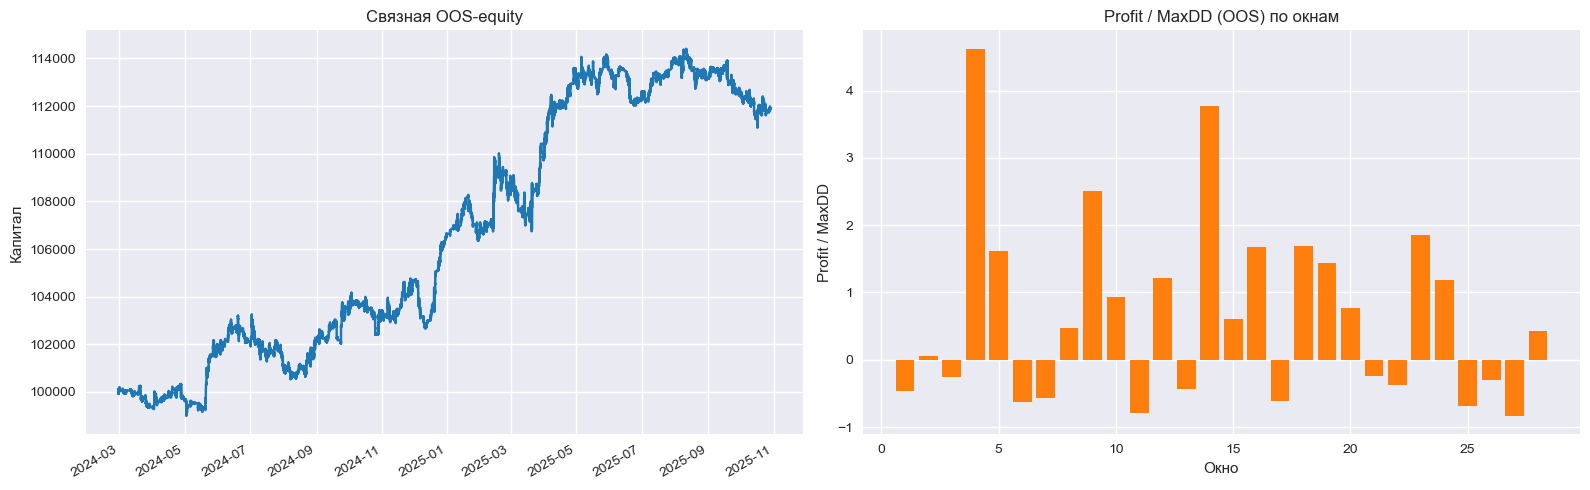

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

if not live_equity.empty:
    live_equity.plot(ax=axes[0], title="Связная OOS-equity", color="#1f77b4")
    axes[0].set_ylabel("Капитал")
else:
    axes[0].text(0.5, 0.5, "Нет данных", ha="center", va="center")

if not windows_summary.empty:
    axes[1].bar(
        windows_summary["window"],
        windows_summary["profit_to_maxdd_oos"],
        color="#ff7f0e",
    )
    axes[1].set_title("Profit / MaxDD (OOS) по окнам")
    axes[1].set_xlabel("Окно")
    axes[1].set_ylabel("Profit / MaxDD")
else:
    axes[1].text(0.5, 0.5, "Нет данных", ha="center", va="center")

plt.tight_layout()
plt.show()

## История лучших параметров

In [12]:
if not param_history.empty:
    display(param_history)

    freq_frames = []
    for column in param_history.columns:
        if column == "window":
            continue
        counts = param_history[column].value_counts().reset_index()
        counts.columns = ["value", "count"]
        counts["parameter"] = column
        freq_frames.append(counts)

    if freq_frames:
        freq_df = pd.concat(freq_frames, ignore_index=True)
        display(freq_df)
else:
    print("Нет истории параметров — проверьте настройки оптимизации.")

,window,KATR,PerATR,SMA,MinRA,FlATR,FlHL,SlopeSignal
0,1,6,60,1,0,0,0,0.0001
1,2,8,60,3,0,0,0,0.0001
2,3,10,60,5,0,0,0,0.0001
3,4,9,30,3,0,0,0,0.0001
4,5,6,30,5,0,0,0,0.0001
5,6,4,10,1,0,0,0,0.0001
6,7,5,10,5,0,0,0,0.0001
7,8,3,60,3,0,0,0,0.0001
8,9,7,10,7,0,0,0,0.0001
9,10,7,60,1,0,0,0,0.0001


,value,count,parameter
0,10.0000,5,KATR
1,2.0000,5,KATR
2,6.0000,4,KATR
3,8.0000,4,KATR
4,7.0000,4,KATR
5,3.0000,3,KATR
6,9.0000,2,KATR
7,4.0000,1,KATR
8,5.0000,1,KATR
9,60.0000,12,PerATR
